In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import from_networkx, to_undirected


In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load and combine the embeddings, ensuring all are reduced to 512 dimensions
embedding_paths = {
    'gene': '/data/luis/Embeddings_512/gene_embeddings_512.csv',
    'drug': '/data/dandreas/cellDrugNet/drug_embeddings_chemberta_512.csv',
    'cell': '/data/luis/Embeddings_512/cell_embeddings_512.csv'
}

In [4]:
def load_embeddings(paths):
    all_embeddings = {}
    for entity_type, path in paths.items():
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            all_embeddings[row[0]] = row[1:].astype(np.float32).values
    return all_embeddings

embeddings = load_embeddings(embedding_paths)

In [5]:
## DATASETS ##
##------------------------------GENE-TO-CELL-----------------------------------##
# Load and preprocess the gene-to-cell dataset
df_gene_cell = pd.read_csv('/data/luis/Datasets/genetocell.csv')  
df_gene_cell = df_gene_cell[['cell', 'gene']]


##------------------------------CELL-TO-DRUG-----------------------------------##
# Load and preprocess the cell-to-drug dataset
df_cell_drug = pd.read_csv('/data/mikaela/Drug_Response_SMILES_transformed_filtered.csv', index_col = 0) 
#print(df_cell_drug.head())
#print("Shape original df_cell_drug: ", df_cell_drug.shape)

# Convert the cell-drug matrix to an edge list
cell_drug_edges = []
for cell in df_cell_drug.index: # Iterate over the row indices (cells) of the DataFrame
    for smiles in df_cell_drug.columns: # Iterate over the column names (SMILES string) of the DataFrame
        if df_cell_drug.loc[cell, smiles] == 1: # If the cell-drug pair has a value of 1 indicating there is a connection
            cell_drug_edges.append([cell, smiles]) # If there is a connection, the pair '[cell, smiles]' is added to the edge list

# Convert edge list to DataFrame
df_cell_drug = pd.DataFrame(cell_drug_edges, columns=['cell', 'SMILES'])
#print("Shape df_cell_drug: ", df_cell_drug.shape)
#print("Shape of cell_drug_edges: ", cell_drug_edges[:5])


##------------------------------GENE-TO-DRUG------------------------------------##
df_gene_drug = pd.read_csv('/data/luis/Datasets/GNN_drug_smiles2_no_NaN.csv')  
df_gene_drug = df_gene_drug[['Gene', 'SMILES2']]
df_gene_drug.rename(columns={'SMILES2': 'SMILES'}, inplace=True)


In [6]:
## PPI DATA ##
ppi_data = pd.read_csv('/data/luis/Datasets/gene_gene_association_f.csv')

In [7]:
genes = np.unique(np.concatenate([df_gene_cell['gene'], df_gene_drug['Gene']]))
cells = np.unique(np.concatenate([df_gene_cell['cell'], df_cell_drug['cell']]))
drugs = np.unique(np.concatenate([df_gene_drug['SMILES'], df_cell_drug['SMILES']]))

print("Length genes: ", len(genes))
print("Length cells: ", len(cells))
print("Length drugs: ", len(drugs))

## MAPPINGS ##
gene2idx = {gene: i for i, gene in enumerate(genes)} # Ex: genes = ['geneA', 'geneB', 'geneC'], gene2idx = {'geneA': 0, 'geneB': 1, 'geneC': 2}
cell2idx = {cell: i + len(genes) for i, cell in enumerate(cells)} # Ex. cells = ['cellX', 'cellY'], cell2idx = {'cellX': 3, 'cellY': 4}
drug2idx = {drug: i + len(genes) + len(cells) for i, drug in enumerate(drugs)} # Ex. drugs = ['drug1', 'drug2'], drug2idx = {'drug1': 5, 'drug2': 6}

Length genes:  19483
Length cells:  1751
Length drugs:  5474


In [8]:
num_nodes = len(genes) + len(cells) + len(drugs) # total number of unique nodes
embedding_dim = 512 #768  # Dimension of node embeddings
node_features = torch.zeros((num_nodes, embedding_dim), dtype=torch.float32) # Initialize node features tensor

In [9]:
# Fill in the node features with the pre-trained embeddings
num_genes = 0
num_cells = 0
num_drugs = 0

for gene in genes:
    if gene in embeddings:
        node_features[gene2idx[gene]] = torch.tensor(embeddings[gene], dtype=torch.float32)
        num_genes += 1
for cell in cells:
    if cell in embeddings:
        node_features[cell2idx[cell]] = torch.tensor(embeddings[cell], dtype=torch.float32)
        num_cells += 1
for drug in drugs:
    if drug in embeddings:
        node_features[drug2idx[drug]] = torch.tensor(embeddings[drug], dtype=torch.float32)
        num_drugs += 1

print(f"Number of genes in embeddings: {num_genes}")
print(f"Number of cells in embeddings: {num_cells}")
print(f"Number of drugs in embeddings: {num_drugs}")

Number of genes in embeddings: 13805
Number of cells in embeddings: 998
Number of drugs in embeddings: 5474


In [10]:
edges = [] # These are positive edges

# gene - cell edges
for _, row in df_gene_cell.iterrows(): # iterrows() method returns an iterator that yields index-value pairs for each row in the DF
    gene_idx = gene2idx[row['gene']] # first iteration: 'row['gene']' = 'geneA', 'gene_idx' = 0 
    cell_idx = cell2idx[row['cell']] # first iteration: 'row['cell']' = 'cellX', 'cell_idx' = 3
    edges.append([gene_idx, cell_idx]) # first iteration: Append '[0, 3]' to 'edges' list

# cell - drug edges
for _, row in df_cell_drug.iterrows():
    cell_idx = cell2idx[row['cell']] # first iteration: 'row['cell']' = 'cellX', 'cell2idx' = 3
    drug_idx = drug2idx[row['SMILES']] # first iteration: 'row['SMILES'] = 'drug1', 'drug2idx' = 5
    edges.append([cell_idx, drug_idx]) # first iteration: Append '[3, 5]'
    
# Drug-Gene edges
for _, row in df_gene_drug.iterrows():
    drug_idx = drug2idx[row['SMILES']] # first iteration: 'row['SMILES']' = 'drug1', 'drug2idx' = 5
    gene_idx = gene2idx[row['Gene']] # first iteration: 'row['Gene']' = 'geneA', 'gene2idx' = 0
    edges.append([drug_idx, gene_idx]) # first iteration: Append '[5, 0]'
edges = np.array(edges)
#print(edges.size)

In [11]:
## Add PPI Edges ##
G = nx.Graph()

## UNDIRECTED EDGES (not used in LoG paper) ##
# for edge in edges:
#     G.add_edge(edge[0], edge[1])
## ---------------------------------------- ##

for _, row in ppi_data.iterrows():
    if row['Gene1'] in gene2idx and row['Gene2'] in gene2idx:
        gene1_idx = gene2idx[row['Gene1']]
        gene2_idx = gene2idx[row['Gene2']]
        G.add_edge(gene1_idx, gene2_idx)


# Add all nodes that are in gene2idx to the graph to avoid missing nodes (undirected convention)
G.add_nodes_from(gene2idx.values())

# Convert the NetworkX graph to PyTorch Geometric format
edge_index = from_networkx(G).edge_index

# Ensure edges are undirected
edge_index = to_undirected(edge_index)

# Convert edge_index back to numpy and extend the edges list
ppi_edges = edge_index.cpu().numpy().T
edges = edges.tolist()
edges.extend(ppi_edges.tolist())

# Convert edges to torch format
edges = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)


/home/mdicome/.conda/envs/GeneLLM/lib/python3.10/site-packages/torch/cuda/__init__.py:173: UserWarning: 
NVIDIA H100 PCIe with CUDA capability sm_90 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 compute_37.
If you want to use the NVIDIA H100 PCIe GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [1]:
## Divide up specific edges: cell - drug edges and all other edges (MIKAELA) ##
## EDGES vs EDGE_INDEX ##
cell_indices_set = set(cell2idx.values())
drug_indices_set = set(drug2idx.values())

cell_drug_edges = []
other_edges = []

for i in range(edges.size(1)):
    src, dst = edges[0, i].item(), edges[1, i].item()
    if (src in cell_indices_set and dst in drug_indices_set) or (src in drug_indices_set and dst in cell_indices_set):
        cell_drug_edges.append([src, dst])
    else:
        other_edges.append([src, dst])

print("cell drug edges: ", len(cell_drug_edges))
print("all other edges: ", len(other_edges))

## Convert edge lists in tensors ##
cell_drug_edges = torch.tensor(cell_drug_edges, dtype=torch.long).t().to(device)
other_edges = torch.tensor(other_edges, dtype=torch.long).t().to(device)

NameError: name 'cell2idx' is not defined

In [38]:
## Split edges into Training and Testing Sets (MIKAELA) ##
# RANDOM CELL - DRUG EDGES SPLIT
train_cell_drug_edges, test_cell_drug_edges = train_test_split(cell_drug_edges.t().cpu().numpy(), test_size=0.2, random_state=1234) # with ppi

# Convert back to PyTorch Tensors
train_cell_drug_edges = torch.tensor(train_cell_drug_edges, dtype=torch.long).t().to(device)
print("Train cell drug edges size: ", train_cell_drug_edges.size(1))
test_cell_drug_edges = torch.tensor(test_cell_drug_edges, dtype=torch.long).t().to(device)
print("Test cell drug edges size: ", test_cell_drug_edges.size(1))

# other edges
# train_other_edges, test_other_edges = train_test_split(other_edges.t().cpu().numpy(), test_size=0.2, random_state=1234) # use with ppi

Train cell drug edges size:  21152
Test cell drug edges size:  5289


In [39]:
## Clone the original edges index for reference ##
## EDGES vs EDGE_INDEX ##
original_edge_index = edges.clone().to(device)

In [40]:
## Remove the edges in cell_drug_edge_index for training ##
## EDGES vs EDGE_INDEX ##
'''
'edge_index.size(1)': retreives the size of the second dimension [2, num_edges] = num_edges and creates a 1D tensor filled with ones with len(num_edges)
'dtype=torch.bool': sets all 1s = True, so each element in tensor will be 'True'.
'device=edge_index.device': ensures the 'mask' tensor is created on the same device as 'edge_index'
'''
mask = torch.ones(edges.size(1), dtype=torch.bool, device=edges.device)

for i in range(cell_drug_edges.size(1)): # iterating over each 'cell_drug_edge', size 'cell_drug_edge.size(1)'
    '''
    'edge_index[0] == cell_drug_edges[0, i]' check source node of any edge in 'edge_index' matches source node in 'cell_drug_edge'
    'edge_index[1] == cell_drug_edges[1, i]' checks if target node of any edge in 'edge_index' matches target node in 'cell_drug_edge'
    '''
    match = (edges[0] == cell_drug_edges[0, i]) & (edges[1] == cell_drug_edges[1, i])
    mask = mask & ~match # Updates 'mask' by setting elements to 'False' where there is a match between an edge in 'edge_index' and the current 'cell_drug_edge'
    # This EXCLUDES these matching edges from further processing
    
# This includes all edges EXCEPT those edges that match in 'edge_index' and 'cell_drug_index' that aren't already in 'train_cell_drug_edges'
train_edge_index = torch.cat([original_edge_index[:, mask], train_cell_drug_edges], dim=1).to(device)
print(train_edge_index.shape)
print("Shape of train_edge_index: ", train_edge_index.size(1))

torch.Size([2, 1333254])
Shape of train_edge_index:  1333254


In [41]:
## Prepare the Data Objects ##
train_data_cd = Data(x=node_features, edge_index=train_cell_drug_edges).to(device) ## drug - cell data object ##
train_data = Data(x=node_features, edge_index=train_edge_index).to(device) # random cell drug edges
test_data = Data(x=node_features, edge_index=test_cell_drug_edges).to(device) # random cell drug edges
# data = Data(x=node_features, edge_index=original_edge_index).to(device) # all edges

print("train_data_cd size: ", train_data_cd.size(1))
print("Number of edges in train_data_cd: ", train_data_cd.edge_index.size(1))
print("train_data size: ", train_data.size(1))
print("Number of edges in train_data: ", train_data.edge_index.size(1))
#print("test_data size: ", test_data.x.shape) # [num_nodes, num_features]
print("Number of edges in test_data: ", test_data.edge_index.size(1))

train_data_cd size:  26714
Number of edges in train_data_cd:  21152
train_data size:  26714
Number of edges in train_data:  1333254
Number of edges in test_data:  5289


In [42]:
## Positive and Negative samples for cell - drug edges ##
def generate_cell_drug_edge_samples_with_split(cell_nodes, drug_nodes, train_pos_edge_index, test_pos_edge_index, num_neg_samples):
    # Generate all possible edges between the given 'cell_nodes' and 'drug_nodes'. Results in every possible pair of cell and drug nodes.
    all_possible_edges = torch.cartesian_prod(cell_nodes, drug_nodes)

    # Convert existing positive edges to a set 
    train_pos_edges_set = set(map(tuple, train_pos_edge_index.t().tolist()))
    test_pos_edges_set = set(map(tuple, test_pos_edge_index.t().tolist()))

    # Combine both sets to exclude any edges that is in either the training or testing positive edge sets
    all_pos_edges_set = test_pos_edges_set.union(train_pos_edges_set)

    # Filter out positive edges to get candidate negative edges
    candidate_neg_edges = [tuple(edge.tolist()) for edge in all_possible_edges if tuple(edge.tolist()) not in all_pos_edges_set]
    
    if len(candidate_neg_edges) < num_neg_samples:
        print(f"Warning: Only {len(candidate_neg_edges)} negative samples available, fewer than requested {num_neg_samples}.")
        num_neg_samples = len(candidate_neg_edges)

    # Randomly select a number of negative samples, from remaining 'candidate_neg_edges', equal to num_neg_samples
    neg_edge_index = torch.tensor(candidate_neg_edges, dtype=torch.long).T
    neg_edge_index = neg_edge_index[:, torch.randperm(neg_edge_index.size(1))[:num_neg_samples]]

    # Split the negative edges into training and testing sets
    split_idx = int(0.8 * num_neg_samples) # Calculate the split index
    neg_train_edge_index = neg_edge_index[:, :split_idx] # Split the negative edges into training set, first 80%
    neg_test_edge_index = neg_edge_index[:, split_idx:] # Split the negative edges into testing set, last 20%


    return neg_train_edge_index, neg_test_edge_index

In [43]:
## train cd negative edges ##
## Preparing cell and drug nodes for intput into generate_cell_drug_edge_samples() ##
cell_nodes = torch.tensor(list(cell2idx.values()), dtype=torch.long).to(device)
drugs_nodes = torch.tensor(list(drug2idx.values()), dtype=torch.long).to(device)

num_train_pos_edges = train_data_cd.edge_index.size(1)
num_test_pos_edges = test_data.edge_index.size(1)

# Total number of positive edges
total_num_pos_edges = num_train_pos_edges + num_test_pos_edges

train_cd_neg_edge, cell_drug_neg_edges = generate_cell_drug_edge_samples_with_split(cell_nodes, drugs_nodes, train_data_cd.edge_index, test_data.edge_index, total_num_pos_edges)

print("train_cd_neg_edge size: ", train_cd_neg_edge.size(1))
print("test size: ", cell_drug_neg_edges.size(1))

train_cd_neg_edge size:  21152
test size:  5289


In [44]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(embedding_dim, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 64)
        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.2)  # Adding Leaky ReLU as non-linearity

    def forward(self, x, edge_index):
        # convolution layer 1
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        # convolution layer 2
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        # convolution layer 3
        x = self.conv3(x, edge_index)
        return x
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

        return logits

In [45]:
model = GCN().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
train_losses = []

def train():
    model.train()
    optimizer.zero_grad()
    z = model(train_data.x, train_data.edge_index) # Message Passing 
    
    pos_samples = train_data_cd.edge_index # for cell -drug edge loss calculation 
    neg_samples = train_cd_neg_edge.to(device)
    labels = torch.cat([torch.ones(pos_samples.size(1)), torch.zeros(neg_samples.size(1))]).to(device) # for cell -drug edge loss calculation
    
    logits = model.decode(z, pos_samples, neg_samples).to(device) # for cell -drug edge loss calculation
    #prob = sigmoid(logits) # get logits between 0 and 1
                        
    loss = criterion(logits, labels) # loss calculation on cell - drug edges
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    return loss.item()


In [46]:
patience = 20 # Number of epochs to wair for improvement
patience_counter = 0 # Keeps track of how many epochs since the last improvement
best_train_loss = float('inf') # Initialize the best loss to infinity

# Training Loop
for epoch in range(1, 1001):
    loss = train()  
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

        if loss < best_train_loss:
            best_train_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping condition based on trainig loss
        if patience_counter >= patience:
            print(f'Early stopping: Training loss has not improved for the last {patience} epochs.')
            break


Epoch 10, Loss: 0.7205
Epoch 20, Loss: 0.7209
Epoch 30, Loss: 0.6982
Epoch 40, Loss: 0.6923
Epoch 50, Loss: 0.6922
Epoch 60, Loss: 0.6909
Epoch 70, Loss: 0.6882
Epoch 80, Loss: 0.6884
Epoch 90, Loss: 0.6914
Epoch 100, Loss: 0.6831
Epoch 110, Loss: 0.6843
Epoch 120, Loss: 0.6783
Epoch 130, Loss: 0.6865
Epoch 140, Loss: 0.6756
Epoch 150, Loss: 0.6754
Epoch 160, Loss: 0.6642
Epoch 170, Loss: 0.6594
Epoch 180, Loss: 0.6519
Epoch 190, Loss: 0.6628
Epoch 200, Loss: 0.6665
Epoch 210, Loss: 0.6547
Epoch 220, Loss: 0.6392
Epoch 230, Loss: 0.6248
Epoch 240, Loss: 0.6091
Epoch 250, Loss: 0.6162
Epoch 260, Loss: 0.6262
Epoch 270, Loss: 0.6398
Epoch 280, Loss: 0.5930
Epoch 290, Loss: 0.6043
Epoch 300, Loss: 0.5874
Epoch 310, Loss: 0.5711
Epoch 320, Loss: 0.6701
Epoch 330, Loss: 0.6350
Epoch 340, Loss: 0.6754
Epoch 350, Loss: 0.6079
Epoch 360, Loss: 0.5588
Epoch 370, Loss: 0.6050
Epoch 380, Loss: 0.5762
Epoch 390, Loss: 0.5499
Epoch 400, Loss: 0.5330
Epoch 410, Loss: 0.5209
Epoch 420, Loss: 0.5355
E

In [49]:
## INCLUDES ALL EDGES (drug, cell, gene nodes) ##

def eval_specific_edges(model, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model(test_data.x, train_data.edge_index)
        logits = model.decode(z, pos_edge_index, neg_edge_index)

    pos_pred = logits[:pos_edge_index.size(1)]
    neg_pred = logits[pos_edge_index.size(1):]

    pos_label = torch.ones(pos_edge_index.size(1), device=device)
    neg_label = torch.zeros(neg_edge_index.size(1), device=device)

    label = torch.cat([pos_label, neg_label]).cpu()
    pred = torch.cat([torch.sigmoid(pos_pred), torch.sigmoid(neg_pred)]).cpu()

    accuracy = accuracy_score(label, (pred > 0.5).int())
    roc_auc = roc_auc_score(label, pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {roc_auc:.4f}')


    # Plot ROC curve
    fpr, tpr, _ = roc_curve(label, pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy, roc_auc

Accuracy: 0.8195
AUC: 0.8866


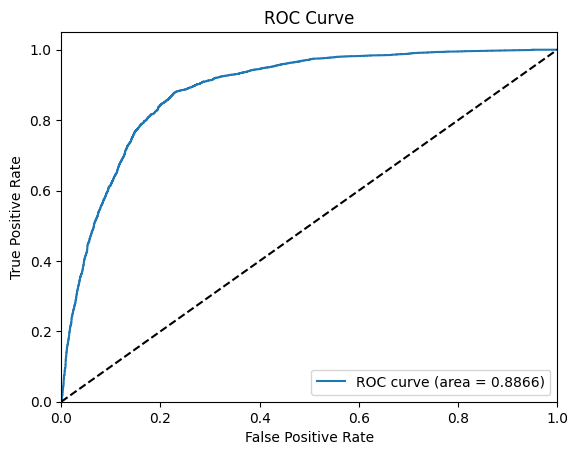

In [50]:
test_auc = eval_specific_edges(model, test_data.edge_index.to(device), cell_drug_neg_edges.to(device))